<a href="https://colab.research.google.com/github/Fr2zyRoom/AIMC_MSK-2/blob/main/MURA_multi_classification_refined_AIMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MURA-musculoskeletal radiographs

## Opening
실습에 앞서 필요한 라이브러리를 내려받습니다.  
**!!필수!!**   
**라이브러리 다운로드에 앞서 [런타임]-[런타임 유형 변경]에서 하드웨어 가속기를 GPU로 변경합니다.  
하드웨어 가속기를 GPU로 변경하면 모든 환경이 reset되기 때문에 꼭! 코드 실행 전에 변경해주시길 바랍니다.  
"!pip install grad-cam" 까지 실행 후에 꼭 [런타임]-[런타임 다시 시작]을 눌러주세요.**  

In [ ]:
!pip install --force-reinstall albumentations==1.0.3

In [ ]:
!pip install timm

In [ ]:
!pip uninstall opencv-python -y

In [ ]:
!pip install opencv-python

In [ ]:
!pip install grad-cam

In [ ]:
!pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip

**[런타임 다시 시작]** 후, Download dataset 부터 시작하시면 됩니다.

## Download dataset
실습을 위한 데이터 및 패키지를 내려받습니다.

In [ ]:
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=14_EaXRUfXWRjDaJwObNrznTiDJ0Ngg2s' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=14_EaXRUfXWRjDaJwObNrznTiDJ0Ngg2s" -O MURA_AIMC_train_data_df.csv && rm -rf ~/cookies.txt

In [ ]:
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1F8NS2Wmy0dkTqrmRGtqYlC-kfUtm7YI4' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1F8NS2Wmy0dkTqrmRGtqYlC-kfUtm7YI4" -O MURA-v1.1_refined.zip && rm -rf ~/cookies.txt

In [ ]:
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1M54AOb-s4y-0LDvYzj4moahry91av49-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1M54AOb-s4y-0LDvYzj4moahry91av49-" -O focal_loss.py && rm -rf ~/cookies.txt

In [ ]:
!unzip MURA-v1.1_refined.zip -d ./MURA-v1.1_refined

## Data information pre-processing

In [2]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchsampler import ImbalancedDatasetSampler
import timm

import os
import time
from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from skimage import exposure
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import metrics
from sklearn.preprocessing import label_binarize

In [35]:
total_data_df_refined = pd.read_csv('MURA_AIMC_train_data_df.csv')

In [36]:
total_data_df_refined

Patient            Study  Category  Label Dataset
0     patient00006  study1_positive         3      2   Train
1     patient00021  study1_positive         1      1   Train
2     patient00032  study1_positive         3      2   Train
3     patient00077  study1_positive         3      2    Test
4     patient00081  study1_positive         3      2   Valid
...            ...              ...       ...    ...     ...
3521  patient11387  study1_negative         0      0   Train
3522  patient11388  study1_negative         0      0    Test
3523  patient11389  study1_negative         0      0   Train
3524  patient11390  study1_negative         0      0   Train
3525  patient11391  study1_negative         0      0   Train

[3526 rows x 5 columns]

## Build pytorch custom dataset

In [5]:
dataroot = 'MURA-v1.1_refined'

In [6]:
def match_data_and_label(dataroot, 
                         label_df):
    """match data(dataroot) and labels(DataFrame)
    Parameters:
        dataroot (str) -- directory to data
        label_df (DataFrame) -- label_dataframe
        label_col (str) -- label column in the label DataFrame 
        
    Return:
        data_label_ls (list) -- a list of data_path and labels(matched)
    """
    data_label_ls=[]
    for patient, study, label in label_df[['Patient','Study','Label']].values:
        datadir = os.path.join(dataroot,patient,study)
        filepath_ls = sorted([os.path.join(datadir,f) for f in os.listdir(datadir) if not f.startswith('.')])
        for filepath in filepath_ls:
            #check dir
            if os.path.exists(filepath):
                data_label_ls.append([filepath,label])
    
    return data_label_ls


def gen_dataset_ls(dataroot, 
                   label_csv_path, 
                   split=None):
    """match data(dataroot) and labels(label_csv)
    Parameters:
        dataroot (str) -- directory to data
        label_csv_path (str) -- a path of csv file
        split (str) --
        
    Return:
        data_label_ls (list) -- a list of data_path and labels(matched)
    """
    label_df = pd.read_csv(label_csv_path)
    if split:
        label_df = label_df[label_df.Dataset == split]
    data_label_ls = match_data_and_label(dataroot, 
                                         label_df)
    return data_label_ls

In [30]:
def img_loader(img_path):
    tmp = np.array(Image.open(img_path))
    #gamma correction
    tmp = exposure.adjust_gamma(tmp, .7)
    return np.stack([tmp]*3,-1)


def get_transform(params=None, mode=None, resize_factor=256, gray_scale=False, convert=True):
    transform_list = []
    #padding
    transform_list.append(
        A.augmentations.geometric.resize.LongestMaxSize(max_size=resize_factor)
    )
    transform_list.append(
        A.augmentations.transforms.PadIfNeeded(min_height=resize_factor, 
                                               min_width=resize_factor, 
                                               border_mode=cv2.BORDER_CONSTANT, 
                                               value=0)
    )
    if mode=='Train':
        ## geometric transform
        transform_list.append(
            A.ShiftScaleRotate(shift_limit=0.03, 
                               scale_limit=0.1, 
                               rotate_limit=10, 
                               p=0.4, 
                               border_mode = cv2.BORDER_CONSTANT)
        )
        ## brightness or contrast
        transform_list.append(
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=0.1, 
                                           contrast_limit=0.1),
                A.RandomGamma(p=1)
            ], p=.3)
        )
        ## blur or sharpen
        transform_list.append(
            A.OneOf([
                A.GaussianBlur(sigma_limit=(0,0.1)),
                A.Sharpen(alpha=(0., 0.1))
            ], p=.2)
        )
    ## normalize
    if convert:
        if gray_scale:
            transform_list.append(
                A.Normalize(mean=[0.5,],
                            std=[0.5,],)
            )
        else:
            transform_list.append(
                A.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],)
            )
        transform_list.append(ToTensorV2())
    
    return A.Compose(transform_list)


class MURADataset(torch.utils.data.Dataset):
    def __init__(self, 
                 data_dir, 
                 csv_path, 
                 img_loader=img_loader,
                 resize_factor=256,
                 gray_scale=False,
                 transform=get_transform,
                 mode=None, 
                 convert=True):
        self.data_dir = data_dir
        self.csv_path = csv_path
        self.img_loader = img_loader
        self.mode = mode
        
        self.transform = transform(mode=self.mode, 
                                   gray_scale=gray_scale,
                                   convert=convert)
        
        data_label_ls = gen_dataset_ls(dataroot=self.data_dir, 
                                       label_csv_path=self.csv_path, 
                                       split=self.mode)
        
        self.data_path, self.labels = list(zip(*data_label_ls))
        
    def __len__(self):
        return len(self.data_path)
    
    def __getitem__(self, index):
        data = self.img_loader(self.data_path[index])
        if self.transform:
            data = self.transform(image=data)['image']
        #label = np.array(self.labels[index]).astype(float)
        
        return data, self.labels[index] #torch.FloatTensor(label)
    
    def get_labels(self):
        return self.labels

In [8]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.axis("off")
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [9]:
aug_dataset = MURADataset(
    data_dir=dataroot,
    csv_path='MURA_train_data_df.csv', 
    resize_factor=256,
    gray_scale=False,
    transform=get_transform,
    mode='Train', 
    convert=False
)

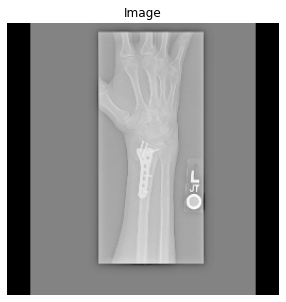

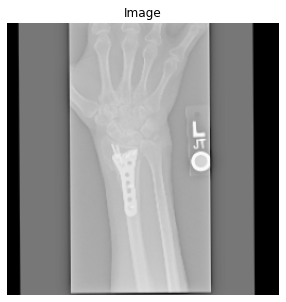

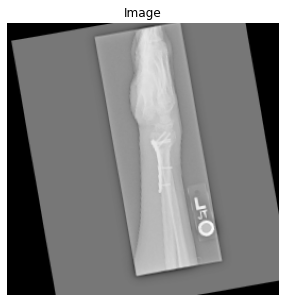

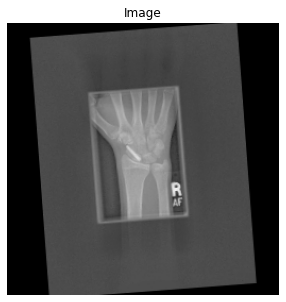

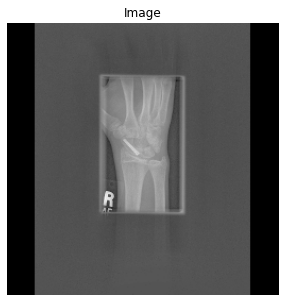

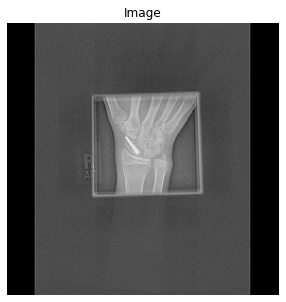

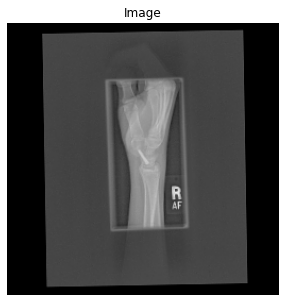

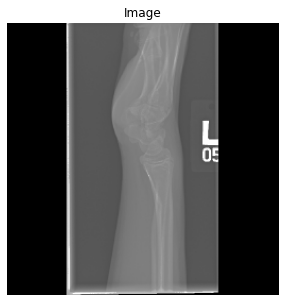

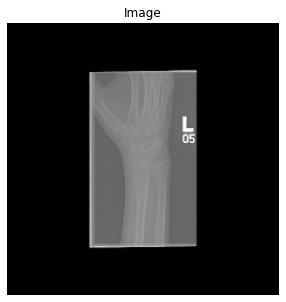

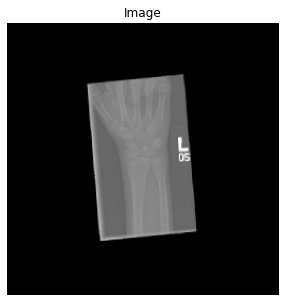

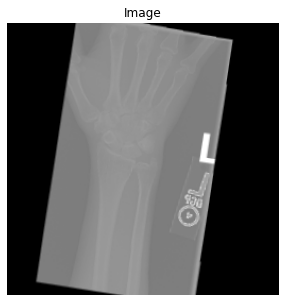

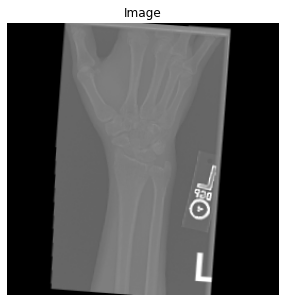

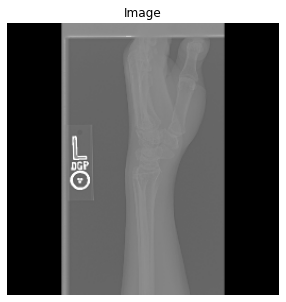

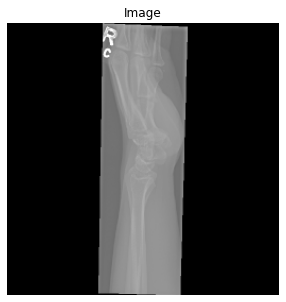

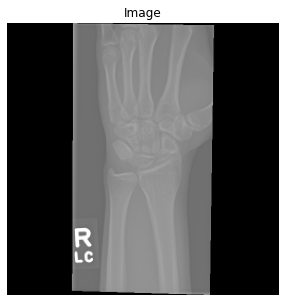

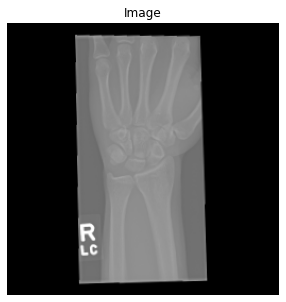

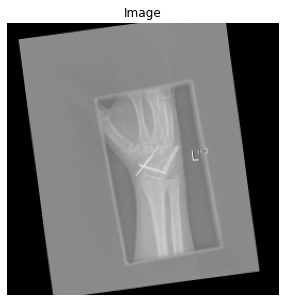

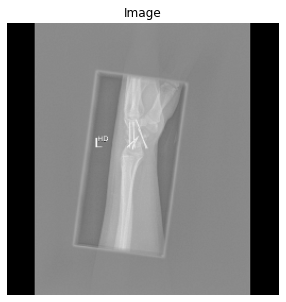

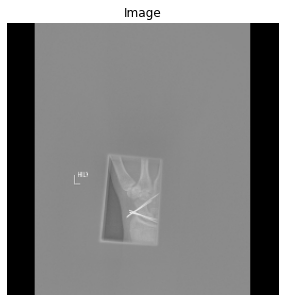

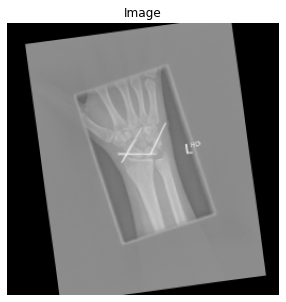

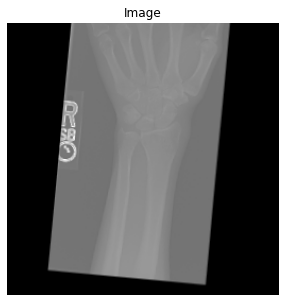

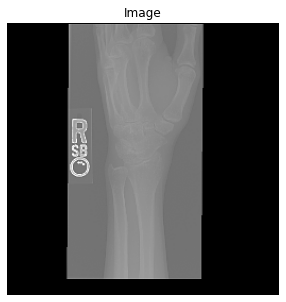

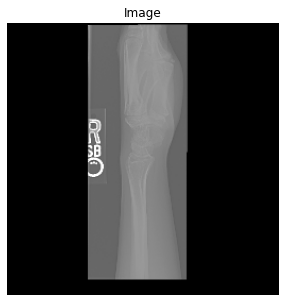

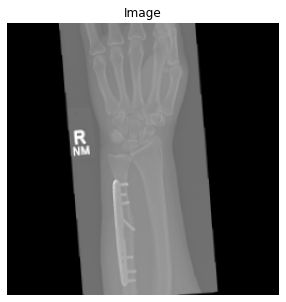

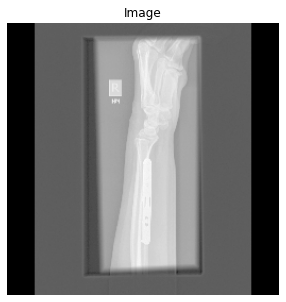

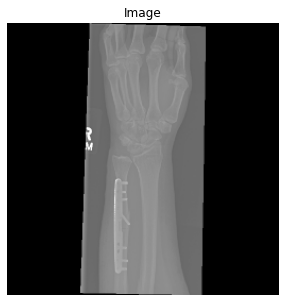

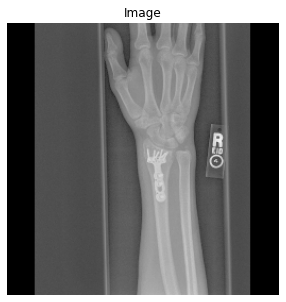

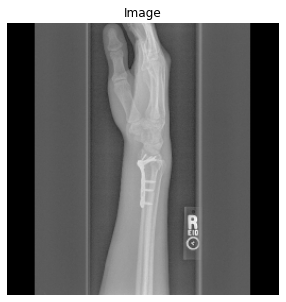

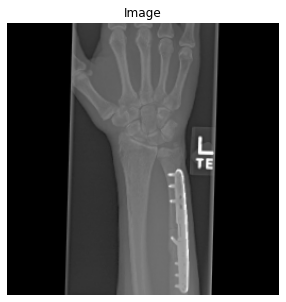

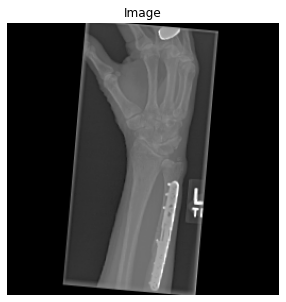

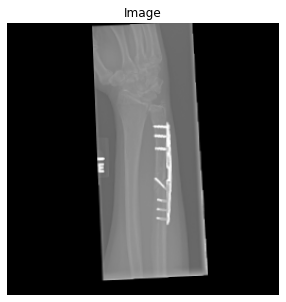

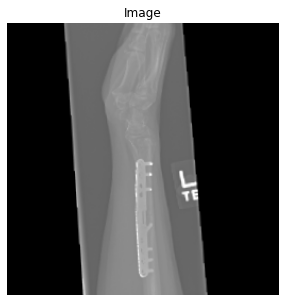

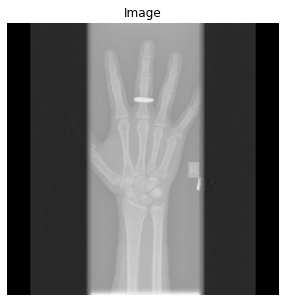

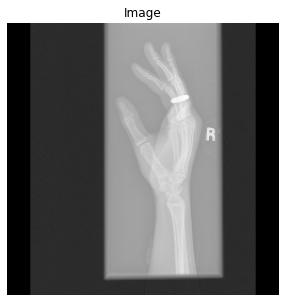

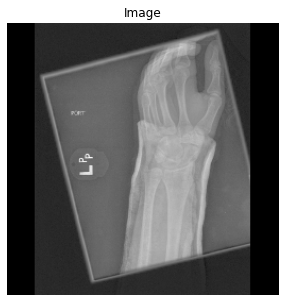

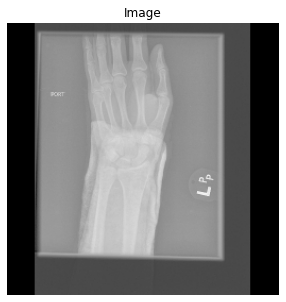

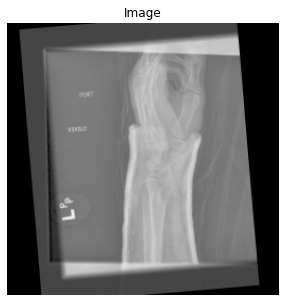

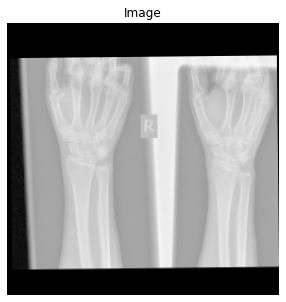

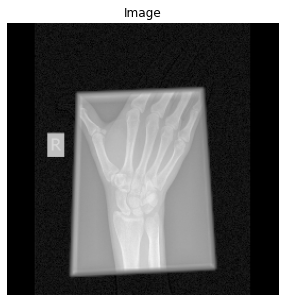

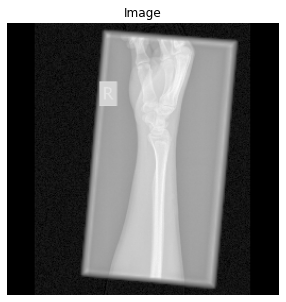

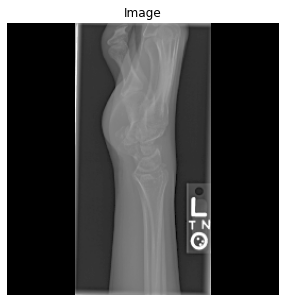

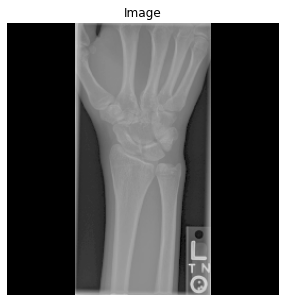

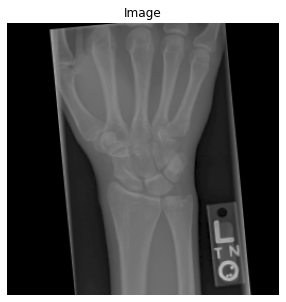

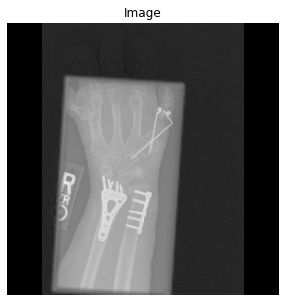

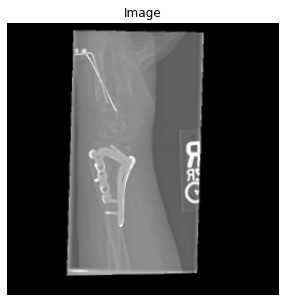

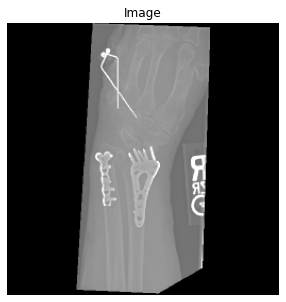

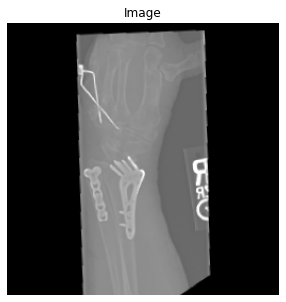

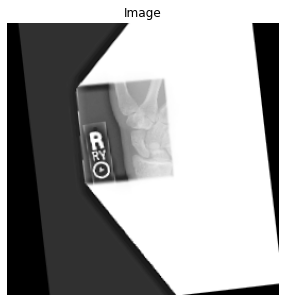

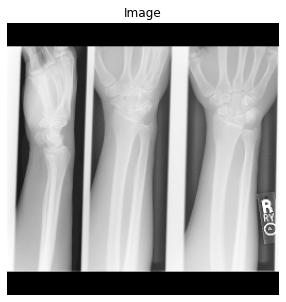

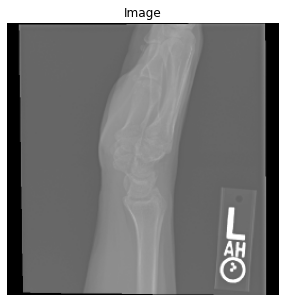

In [10]:
# check augmentation 
for i in range(0,50):
    image, label = aug_dataset[i] 
    visualize(image=image)

## Train model

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            #self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            #self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


class AverageMeter(object):
    """
    Computes and stores the average and current value
    Copied from: https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train_epoch(model, loader, optimizer, criterion, epoch, n_epochs, print_freq=3):
    batch_time = AverageMeter()
    losses = AverageMeter()
    error = AverageMeter()

    # Model on train mode
    model.cuda()
    model.train()

    end = time.time()
    for batch_idx, (input, target) in enumerate(loader):
        # Create vaiables
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        batch_size = target.size(0)
        _, pred = output.data.cpu().topk(1, dim=1)
        error.update(torch.ne(pred.squeeze(), target.cpu()).float().sum().item() / batch_size, batch_size)
        losses.update(loss.item(), batch_size)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # print stats
        if batch_idx % print_freq == 0:
            res = '\t'.join([
                'Epoch: [%d/%d]' % (epoch + 1, n_epochs),
                'Iter: [%d/%d]' % (batch_idx + 1, len(loader)),
                'Time %.3f (%.3f)' % (batch_time.val, batch_time.avg),
                'Loss %.4f (%.4f)' % (losses.val, losses.avg),
                'Error %.4f (%.4f)' % (error.val, error.avg),
            ])
            print(res)

    # Return summary statistics
    return batch_time.avg, losses.avg, error.avg


def test_epoch(model, loader, criterion, print_freq=2, is_test=True):
    batch_time = AverageMeter()
    losses = AverageMeter()
    error = AverageMeter()

    # Model on eval mode
    model.cuda()
    model.eval()

    end = time.time()
    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(loader):
            # Create vaiables
            if torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            batch_size = target.size(0)
            _, pred = output.data.cpu().topk(1, dim=1)
            error.update(torch.ne(pred.squeeze(), target.cpu()).float().sum().item() / batch_size, batch_size)
            losses.update(loss.item(), batch_size)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            # print stats
            if batch_idx % print_freq == 0:
                res = '\t'.join([
                    'Test' if is_test else 'Valid',
                    'Iter: [%d/%d]' % (batch_idx + 1, len(loader)),
                    'Time %.3f (%.3f)' % (batch_time.val, batch_time.avg),
                    'Loss %.4f (%.4f)' % (losses.val, losses.avg),
                    'Error %.4f (%.4f)' % (error.val, error.avg),
                ])
                print(res)

    # Return summary statistics
    return batch_time.avg, losses.avg, error.avg


def train(model, criterion, train_set, valid_set, test_set, save, n_epochs=300,
          batch_size=64, lr=0.0001, patience=10, save_epoch=10, seed=None, 
          train_print_freq=100, test_print_freq=10):
    cnt=0
    if seed is not None:
        torch.manual_seed(seed)

    # Data loaders
    train_loader = torch.utils.data.DataLoader(train_set,
                                               batch_size=batch_size, drop_last=True, shuffle=True, #sampler=ImbalancedDatasetSampler(train_set),
                                               pin_memory=(torch.cuda.is_available()), num_workers=0)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False,
                                              pin_memory=(torch.cuda.is_available()), num_workers=0)
    
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    if valid_set is None:
        valid_loader = None
    else:
        valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False,
                                                   pin_memory=(torch.cuda.is_available()), num_workers=0)
    # Model on cuda
    if torch.cuda.is_available():
        model = model.cuda()

    # Wrap model for multi-GPUs, if necessary
    model_wrapper = model
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        model_wrapper = torch.nn.DataParallel(model).cuda()

    # Optimizer
    optimizer = torch.optim.Adam(model_wrapper.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0.5 * n_epochs, 0.75 * n_epochs],
                                                     gamma=0.1)

    # Start log
    with open(os.path.join(save, 'results.csv'), 'w') as f:
        f.write('epoch,train_loss,train_error,valid_loss,valid_error,test_error\n')

    # Train model
    best_error = 1
    best_loss = 5
    for epoch in range(n_epochs):
        _, train_loss, train_error = train_epoch(
            model=model_wrapper,
            loader=train_loader,
            optimizer=optimizer, 
            criterion=criterion,
            epoch=epoch,
            n_epochs=n_epochs, 
            print_freq=train_print_freq
        )
        scheduler.step()
        _, valid_loss, valid_error = test_epoch(
            model=model_wrapper,
            loader=valid_loader if valid_loader else test_loader,
            criterion=criterion,
            print_freq=test_print_freq,
            is_test=(not valid_loader)
        )

        # Determine if model is the best
        if valid_loader:
            if valid_error < best_error:
                best_error = valid_error
                print('New best error: %.4f' % best_error)
                torch.save(model.state_dict(), os.path.join(save, 'model_epoch'+str(cnt).zfill(3)+'.dat'))
                torch.save(model.state_dict(), os.path.join(save, 'model_err_best.dat'))
            if valid_loss < best_loss:
                best_loss = valid_loss
                print('New best loss: %.4f' % best_loss)
                torch.save(model.state_dict(), os.path.join(save, 'model_epoch'+str(cnt).zfill(3)+'.dat'))
                torch.save(model.state_dict(), os.path.join(save, 'model_los_best.dat'))
        else:
            if (cnt%save_epoch==0):
                torch.save(model.state_dict(), os.path.join(save, 'model_epoch'+str(cnt).zfill(3)+'.dat'))

        # Log results
        with open(os.path.join(save, 'results.csv'), 'a') as f:
            f.write('%03d,%0.6f,%0.6f,%0.5f,%0.5f,\n' % (
                (epoch + 1),
                train_loss,
                train_error,
                valid_loss,
                valid_error,
            ))
        cnt+=1
        
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    torch.save(model.state_dict(), os.path.join(save, 'model_final.dat'))

    # Final test of model on test set
    model.load_state_dict(torch.load(os.path.join(save, 'model_final.dat')))
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model).cuda()
    test_results = test_epoch(
        model=model,
        loader=test_loader,
        criterion=criterion,
        is_test=True
    )
    _, _, test_error = test_results
    with open(os.path.join(save, 'results.csv'), 'a') as f:
        f.write(',,,,,%0.5f\n' % (test_error))
    print('Final test error: %.4f' % test_error)

In [ ]:
from focal_loss import *

In [37]:
###################OPTION###################
dataroot='MURA-v1.1_refined'
csvpath='MURA_AIMC_train_data_df.csv'
savepoint='multi_classs_ckpt'
name='ResNet152_focal_gamma_trial01'
##data##
resize_factor=256
gray_scale=False
##model##
select_model='ResNet152' #ResNet50 / ResNet152 / ResNet200 / DenseNet121 / DenseNet169 / efficientnet_b0 / efficientnet_b4
loss_func='focal' #focal / alpha_focal / cross_entropy
##optimize##
batch_size=16
n_epochs=300
lr=0.0001
patience=5
train_print_freq=100
test_print_freq=10
############################################

In [14]:
save=os.path.join(savepoint, name)

In [ ]:
# Datasets
train_dataset = MURADataset(
    data_dir=dataroot,
    csv_path=csvpath, 
    resize_factor=resize_factor,
    gray_scale=gray_scale,
    transform=get_transform,
    mode='Train', 
    convert=True
)
val_dataset = MURADataset(
    data_dir=dataroot,
    csv_path=csvpath, 
    resize_factor=resize_factor,
    gray_scale=gray_scale,
    transform=get_transform,
    mode='Valid', 
    convert=True
)
test_dataset = MURADataset(
    data_dir=dataroot,
    csv_path=csvpath, 
    resize_factor=resize_factor,
    gray_scale=gray_scale,
    transform=get_transform,
    mode='Test', 
    convert=True
)

if select_model == 'ResNet50':
    model = timm.create_model('resnet50d', pretrained=True)
    if gray_scale:
        model.conv1[0]=torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model.fc = torch.nn.Linear(model.fc.in_features, out_features=3, bias=True)
elif select_model == 'ResNet152':
    model = timm.create_model('resnet152d', pretrained=True)
    if gray_scale:
        model.conv1[0]=torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model.fc = torch.nn.Linear(model.fc.in_features, out_features=3, bias=True)
elif select_model == 'ResNet200':
    model = timm.create_model('resnet200d', pretrained=True)
    if gray_scale:
        model.conv1[0]=torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model.fc = torch.nn.Linear(model.fc.in_features, out_features=3, bias=True)
elif select_model == 'DenseNet121':
    model = timm.create_model('densenet121', pretrained=True)
    if gray_scale:
        model.conv1[0]=torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model.classifier = torch.nn.Linear(model.classifier.in_features, out_features=3, bias=True)
elif select_model == 'DenseNet169':
    model = timm.create_model('densenet169', pretrained=True)
    if gray_scale:
        model.conv1[0]=torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model.classifier = torch.nn.Linear(model.classifier.in_features, out_features=3, bias=True)
elif select_model == 'efficientnet_b0':
    model = timm.create_model('efficientnet_b0', pretrained=True)
    if gray_scale:
        model.conv1[0]=torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model.classifier = torch.nn.Linear(model.classifier.in_features, out_features=3, bias=True)
elif select_model == 'efficientnet_b4':
    model = timm.create_model('efficientnet_b4', pretrained=True)
    if gray_scale:
        model.conv1[0]=torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model.classifier = torch.nn.Linear(model.classifier.in_features, out_features=3, bias=True)
else:
    model = timm.create_model('resnet152d', pretrained=True)
    if gray_scale:
        model.conv1[0]=torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model.fc = torch.nn.Linear(model.fc.in_features, out_features=3, bias=True)

#print(model)

if loss_func == 'cross_entropy':
    criterion = torch.nn.functional.cross_entropy
elif loss_func == 'focal':
    criterion = FocalLoss(gamma=2.)
elif loss_func == 'alpha_focal':
    criterion = FocalLoss(torch.tensor([0.5, 1., 0.1]).cuda(), gamma=2.) #0.3, 0.5, 0.2
else:
    criterion = torch.nn.functional.cross_entropy

# Print number of parameters
num_params = sum(p.numel() for p in model.parameters())
print("Total parameters: ", num_params)

# Make save directory
if not os.path.exists(save):
    os.makedirs(save)
if not os.path.isdir(save):
    raise Exception('%s is not a dir' % save)

# Train the model
train(model=model, 
      criterion=criterion,
      train_set=train_dataset, 
      valid_set=val_dataset, 
      test_set=test_dataset, 
      save=save,
      n_epochs=n_epochs, 
      batch_size=batch_size, 
      lr=lr, 
      patience=patience, 
      train_print_freq=train_print_freq, 
      test_print_freq=test_print_freq)
print('Model traing done!')

## Valdation model & Validation metrics

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def test_acc(testloader, model, n_class, threshold=0.5):
    correct = 0
    total = 0
    output_arr = np.ones((1, n_class))
    label_arr = np.array([])
    pred_arr = np.array([])
    model.cuda()
    model.eval()
   

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) # argmax
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            output_arr = np.concatenate((output_arr, outputs.softmax(1).cpu().numpy()), axis=0)
            label_arr = np.concatenate((label_arr, labels.cpu().numpy()), axis=0)
            pred_arr = np.concatenate((pred_arr, predicted.cpu().numpy()), axis=0)

    output_arr = np.delete(output_arr, 0, axis=0)
    acc = correct/total
    print('Accuracy on the test images: ', (100*correct/total))
    return acc, output_arr, label_arr, pred_arr

In [19]:
select_model='ResNet152' #ResNet50 / ResNet152 / ResNet200 / DenseNet121 / DenseNet169 / efficientnet_b0 / efficientnet_b4
save = 'multi_classs_ckpt/ResNet152_focal_gamma_trial01'

In [20]:
if select_model == 'ResNet50':
    test_model = timm.create_model('resnet50d', pretrained=True)
    if gray_scale:
        test_model.conv1[0]=torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    test_model.fc = torch.nn.Linear(test_model.fc.in_features, out_features=3, bias=True)
elif select_model == 'ResNet152':
    test_model = timm.create_model('resnet152d', pretrained=True)
    if gray_scale:
        test_model.conv1[0]=torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    test_model.fc = torch.nn.Linear(test_model.fc.in_features, out_features=3, bias=True)
elif select_model == 'ResNet200':
    test_model = timm.create_model('resnet200d', pretrained=True)
    if gray_scale:
        test_model.conv1[0]=torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    test_model.fc = torch.nn.Linear(test_model.fc.in_features, out_features=3, bias=True)
elif select_model == 'DenseNet121':
    test_model = timm.create_model('densenet121', pretrained=True)
    if gray_scale:
        test_model.conv1[0]=torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    test_model.classifier = torch.nn.Linear(test_model.classifier.in_features, out_features=3, bias=True)
elif select_model == 'DenseNet169':
    test_model = timm.create_model('densenet169', pretrained=True)
    if gray_scale:
        test_model.conv1[0]=torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    test_model.classifier = torch.nn.Linear(test_model.classifier.in_features, out_features=3, bias=True)
elif select_model == 'efficientnet_b0':
    test_model = timm.create_model('efficientnet_b0', pretrained=True)
    if gray_scale:
        test_model.conv1[0]=torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    test_model.classifier = torch.nn.Linear(test_model.classifier.in_features, out_features=3, bias=True)
elif select_model == 'efficientnet_b4':
    test_model = timm.create_model('efficientnet_b4', pretrained=True)
    if gray_scale:
        test_model.conv1[0]=torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    test_model.classifier = torch.nn.Linear(test_model.classifier.in_features, out_features=3, bias=True)
else:
    test_model = timm.create_model('resnet152d', pretrained=True)
    if gray_scale:
        test_model.conv1[0]=torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    test_model.fc = torch.nn.Linear(test_model.fc.in_features, out_features=3, bias=True)
test_model.load_state_dict(torch.load(os.path.join(save, 'model_los_best.dat')))

<All keys matched successfully>

### Download trained weight
아래 두 셀의 주석을 풀고 실행시켜주면 사전에 학습시켜둔 모델을 불러올 수 있습니다.  
주석은 코드를 드래그하고 ctrl+/을 누르면 한번에 풀 수 있습니다. 

In [ ]:
# !wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1tjQLxlemtnCAM3u1DSDzYPHzlhi41Omb' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1tjQLxlemtnCAM3u1DSDzYPHzlhi41Omb" -O AIMC_fracture_model_los_best.dat && rm -rf ~/cookies.txt

In [ ]:
# # Models(ResNet)
# save = './'
# test_model = timm.create_model('resnet152d', pretrained=True)
# if gray_scale:
#     test_model.conv1[0]=torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
# test_model.fc = torch.nn.Linear(test_model.fc.in_features, out_features=3, bias=True)

# test_model.load_state_dict(torch.load(os.path.join(save, 'AIMC_fracture_model_los_best.dat')))

In [23]:
class_name = ['Normal', 'Init frac+splint', 'Metal']

In [38]:
test_dataset = MURADataset(
    data_dir=dataroot,
    csv_path=csvpath,  
    resize_factor=resize_factor,
    gray_scale=gray_scale,
    transform=get_transform,
    mode='Test', 
    convert=True
)
intest_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                            pin_memory=(torch.cuda.is_available()), num_workers=8)

In [39]:
acc, output_arr, label_arr, pred_arr = test_acc(intest_loader, test_model, len(class_name))

100%|██████████| 122/122 [00:06<00:00, 17.68it/s]

Accuracy on the test images:  94.8125321006677


In [40]:
print(metrics.classification_report(label_arr, pred_arr))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96      1277
         1.0       0.93      0.68      0.79       261
         2.0       0.99      0.99      0.99       409

    accuracy                           0.95      1947
   macro avg       0.95      0.89      0.91      1947
weighted avg       0.95      0.95      0.94      1947



Text(0.5, 51.0, 'Predicted class')

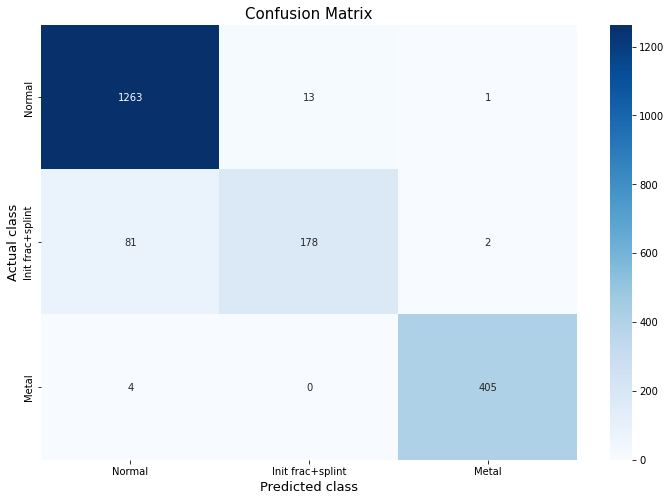

In [41]:
cf_matrix = metrics.confusion_matrix(label_arr, pred_arr)

fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(cf_matrix, 
            xticklabels=class_name, 
            yticklabels=class_name, 
            annot=True, fmt = 'd', cmap='Blues')

plt.title('Confusion Matrix', size = 15)
plt.ylabel('Actual class', size = 13)
plt.xlabel('Predicted class', size = 13) 

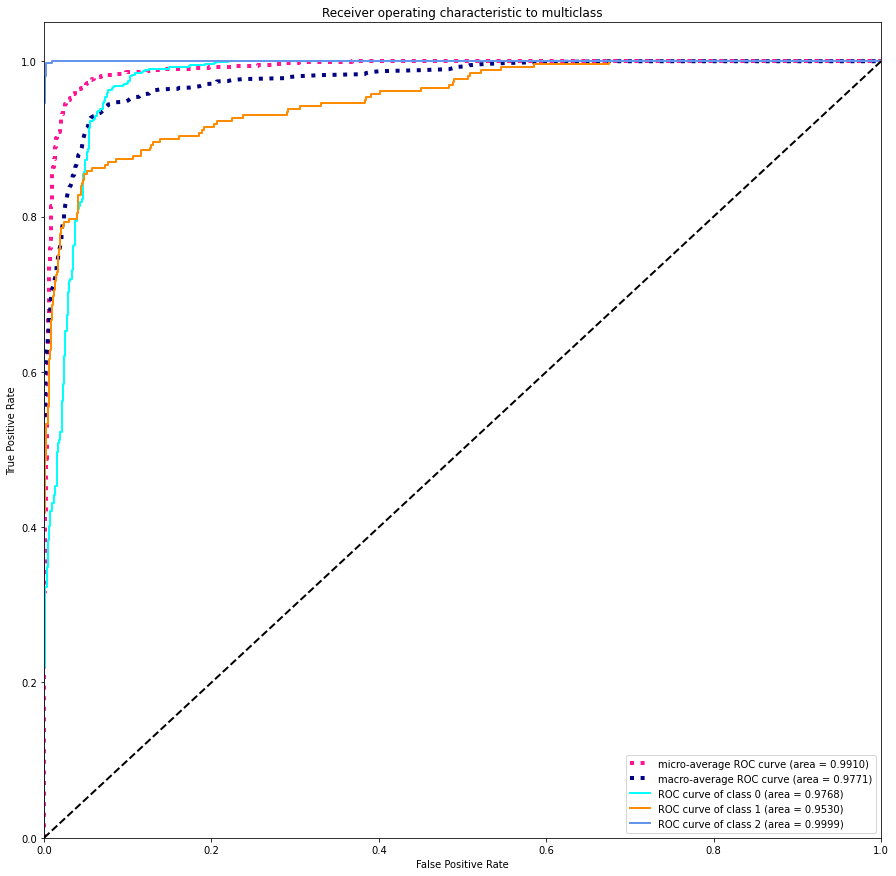

In [42]:
# Compute ROC curve and ROC area for each class
colors = cycle(["aqua", "darkorange", "cornflowerblue", "darkgreen", "blueviolet"])
label_arr_bin = label_binarize(label_arr, classes=list(range(len(class_name))))
n_classes = len(class_name)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(label_arr_bin[:, i], output_arr[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(label_arr_bin.ravel(), output_arr.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,15))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.4f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.4f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),
    )


plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

## Grad-CAM

In [43]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

In [44]:
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category
    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]

In [45]:
test_dataset = MURADataset(
    data_dir=dataroot,
    csv_path=csvpath, 
    resize_factor=resize_factor,
    gray_scale=gray_scale,
    transform=get_transform,
    mode='Test', 
    convert=True
)
test_dataset_vis = MURADataset(
    data_dir=dataroot,
    csv_path=csvpath, 
    resize_factor=resize_factor,
    gray_scale=gray_scale,
    transform=get_transform,
    mode='Test', 
    convert=False
)

In [46]:
start_idx = 105
end_idx = 107

In [47]:
LABEL_INT2STR = {0:'Normal', 
                 1:'Frac + splint',
                 2:'metal'}

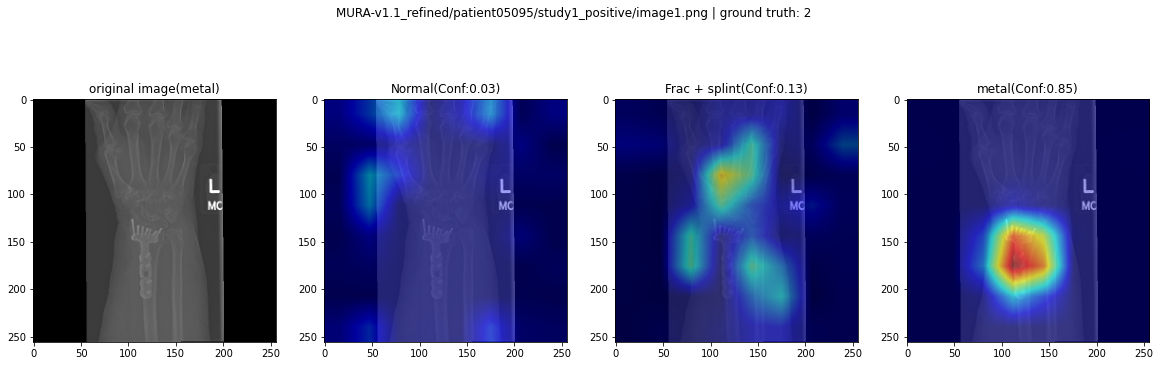

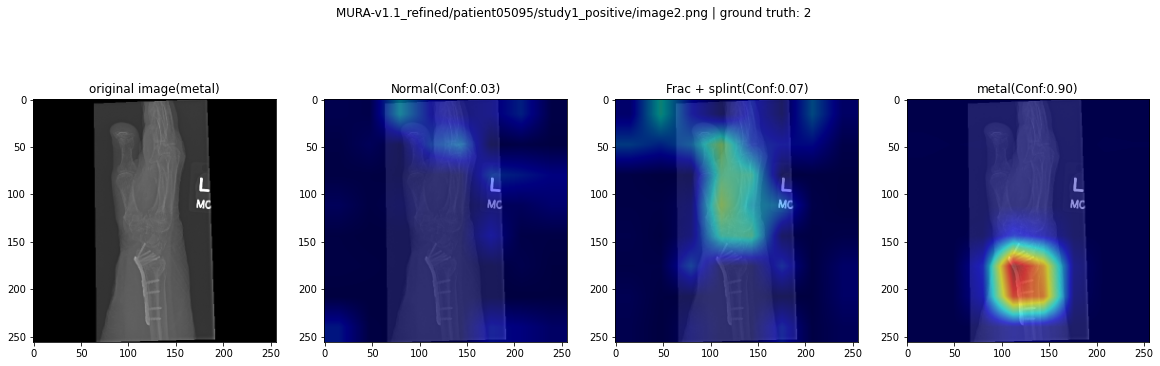

In [49]:
target_layer = [test_model.layer4[-1]]
cam = GradCAM(model=test_model, target_layers=target_layer, use_cuda=True)

for i in range(start_idx, end_idx):
    feature, label = test_dataset[i]
    img, _ = test_dataset_vis[i]
    feature = torch.unsqueeze(feature, 0)
    img = img.astype(np.float)/255
    
    class_cam_image = []
    
    for l in range(len(LABEL_INT2STR)):
        class_cam = cam(input_tensor=feature, targets=[ClassifierOutputTarget(l)],aug_smooth=True,eigen_smooth=False)
        class_cam = class_cam[0, :]
        class_cam_image.append(show_cam_on_image(img, class_cam, use_rgb=True))
    
    prob = test_model(feature.cuda()).softmax(1)[0].cpu().data.numpy()
    #print(test_model(features.cuda()).softmax(1)[0][1], labels)
    fig,ax = plt.subplots(1, 4, figsize=(20, 15))
    ax[0].imshow(img)
    ax[0].set_title(f'original image({LABEL_INT2STR[label]})')
    for l in range(len(LABEL_INT2STR)):
        ax[l+1].imshow(class_cam_image[l])
        ax[l+1].set_title(f'{LABEL_INT2STR[l]}(Conf:{prob[l]:.2f})')
        
    plt.suptitle(f'{test_dataset.data_path[i]} | ground truth: {label}',y=.7)

## Get Top-N FP,FN,TP,TN of the class

In [70]:
test_result_df = pd.DataFrame(np.array(test_dataset.data_path), columns=['Filedir'])
test_result_df = pd.concat([test_result_df, 
                            pd.DataFrame(np.array(output_arr), columns=['Conf_0', 'Conf_1', 'Conf_2']),
                            pd.DataFrame(np.array(pred_arr), columns=['Pred']),
                            pd.DataFrame(np.array(label_arr), columns=['Label'])],axis=1)
test_result_df = test_result_df.astype({'Pred':np.uint8, 
                                        'Label':np.uint8})

In [65]:
#확인하고자 하는 Class
# 0. 정상
# 1. 순수하게 initial fracture 사진 + fracture 이고 splint한 사진 
# 2. fracture이고 수술하여 metal 들어간 사진  

_class = 1

In [66]:
#Display Top-N FP,FN,TP,TN
N=3

### Top-N FalsePositive

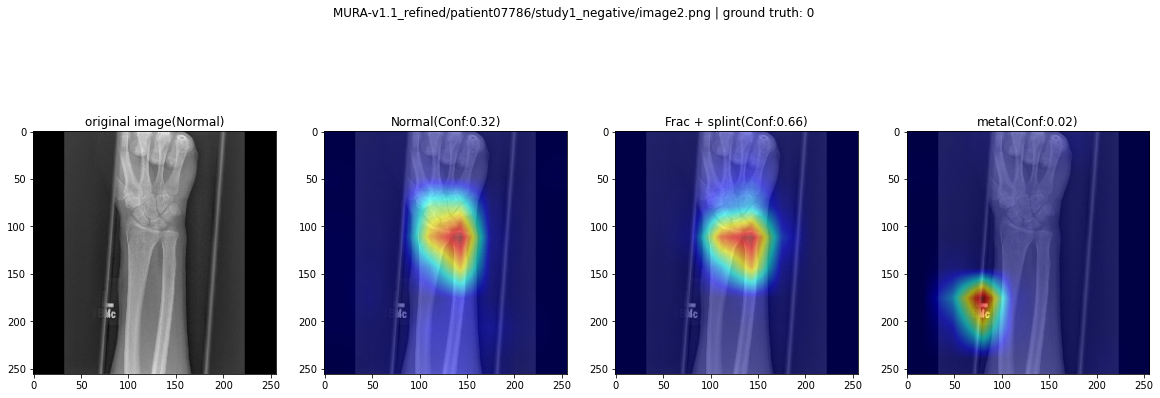

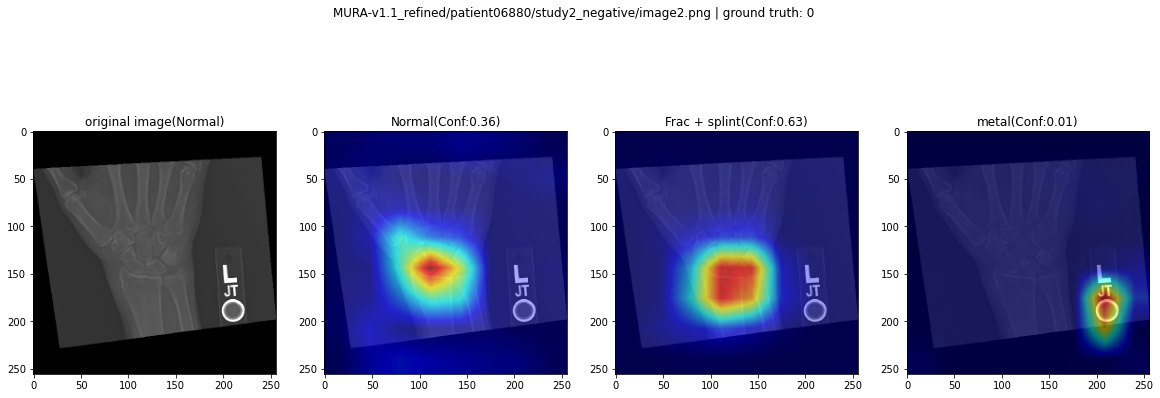

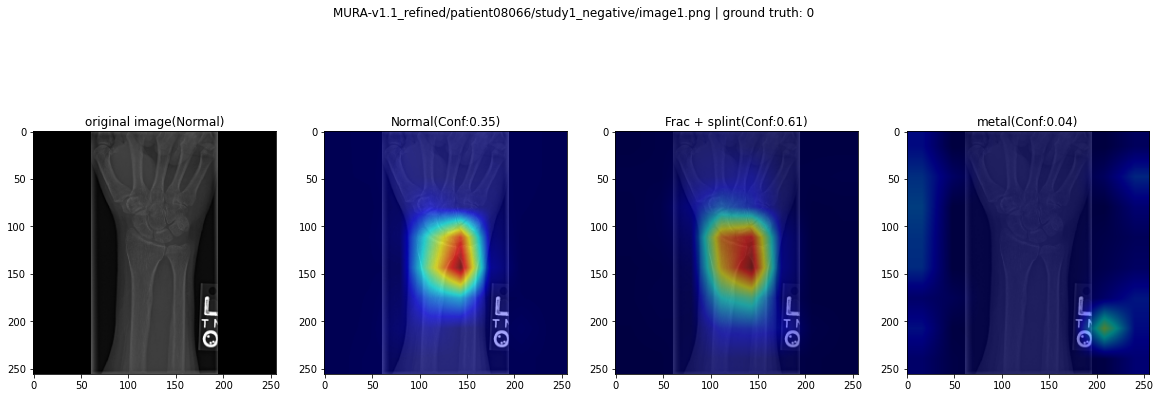

In [67]:
#Top-N FalsePositive

FP_idx_ls = list(test_result_df[test_result_df.Label != _class].sort_values(by=f'Conf_{_class}',ascending=False).index)

target_layer = [test_model.layer4[-1]]
cam = GradCAM(model=test_model, target_layers=target_layer, use_cuda=True)

for i in FP_idx_ls[:N]:
    feature, label = test_dataset[i]
    img, _ = test_dataset_vis[i]
    feature = torch.unsqueeze(feature, 0)
    img = img.astype(np.float)/255
    
    class_cam_image = []
    
    for l in range(len(LABEL_INT2STR)):
        class_cam = cam(input_tensor=feature, targets=[ClassifierOutputTarget(l)],aug_smooth=True,eigen_smooth=False)
        class_cam = class_cam[0, :]
        class_cam_image.append(show_cam_on_image(img, class_cam, use_rgb=True))
    
    prob = test_model(feature.cuda()).softmax(1)[0].cpu().data.numpy()
    #print(test_model(features.cuda()).softmax(1)[0][1], labels)
    fig,ax = plt.subplots(1, 4, figsize=(20, 15))
    ax[0].imshow(img)
    ax[0].set_title(f'original image({LABEL_INT2STR[label]})')
    for l in range(len(LABEL_INT2STR)):
        ax[l+1].imshow(class_cam_image[l])
        ax[l+1].set_title(f'{LABEL_INT2STR[l]}(Conf:{prob[l]:.2f})')
        
    plt.suptitle(f'{test_dataset.data_path[i]} | ground truth: {label}',y=.73) 

### Top-N TrueNegative

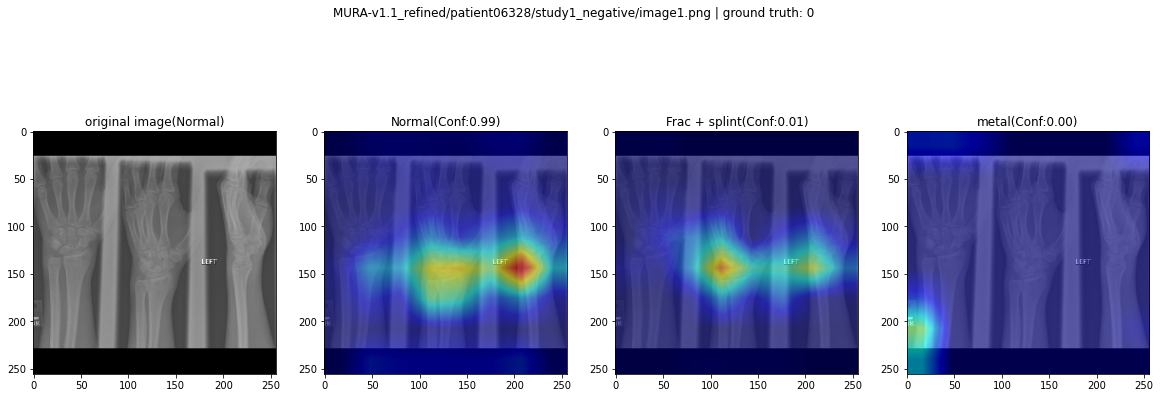

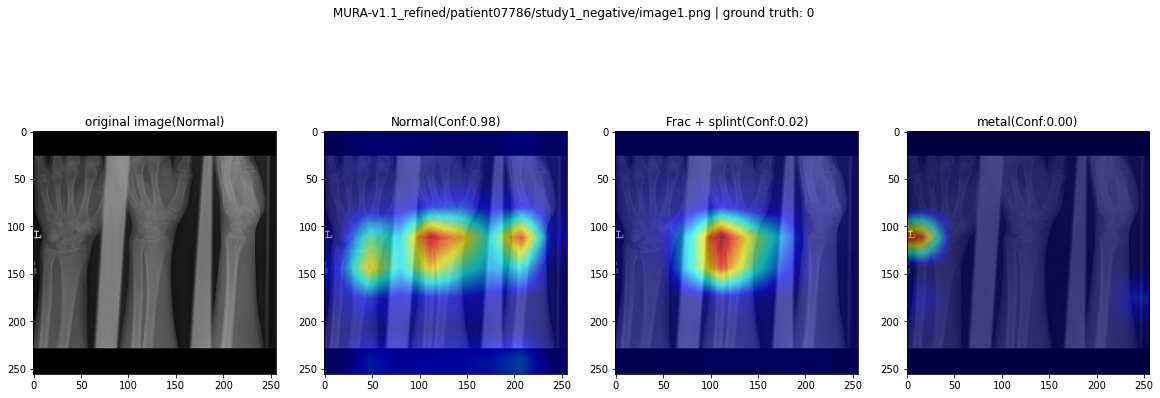

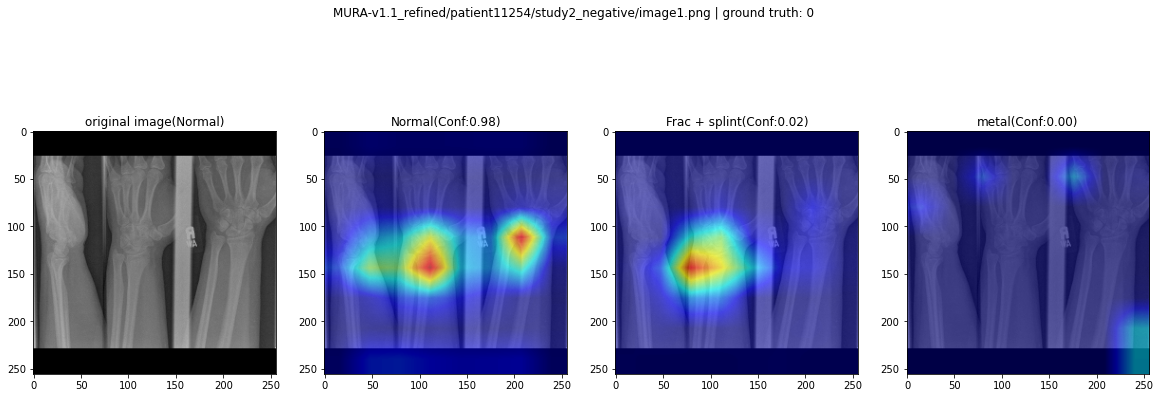

In [54]:
#Top-N TrueNegative

TN_idx_ls = list(test_result_df[test_result_df.Label != _class].sort_values(by=f'Conf_{_class}',ascending=True).index)

target_layer = [test_model.layer4[-1]]
cam = GradCAM(model=test_model, target_layers=target_layer, use_cuda=True)

for i in TN_idx_ls[:N]:
    feature, label = test_dataset[i]
    img, _ = test_dataset_vis[i]
    feature = torch.unsqueeze(feature, 0)
    img = img.astype(np.float)/255
    
    class_cam_image = []
    
    for l in range(len(LABEL_INT2STR)):
        class_cam = cam(input_tensor=feature, targets=[ClassifierOutputTarget(l)],aug_smooth=True,eigen_smooth=False)
        class_cam = class_cam[0, :]
        class_cam_image.append(show_cam_on_image(img, class_cam, use_rgb=True))
    
    prob = test_model(feature.cuda()).softmax(1)[0].cpu().data.numpy()
    #print(test_model(features.cuda()).softmax(1)[0][1], labels)
    fig,ax = plt.subplots(1, 4, figsize=(20, 15))
    ax[0].imshow(img)
    ax[0].set_title(f'original image({LABEL_INT2STR[label]})')
    for l in range(len(LABEL_INT2STR)):
        ax[l+1].imshow(class_cam_image[l])
        ax[l+1].set_title(f'{LABEL_INT2STR[l]}(Conf:{prob[l]:.2f})')
        
    plt.suptitle(f'{test_dataset.data_path[i]} | ground truth: {label}',y=.73)

### Top-N FalseNegative

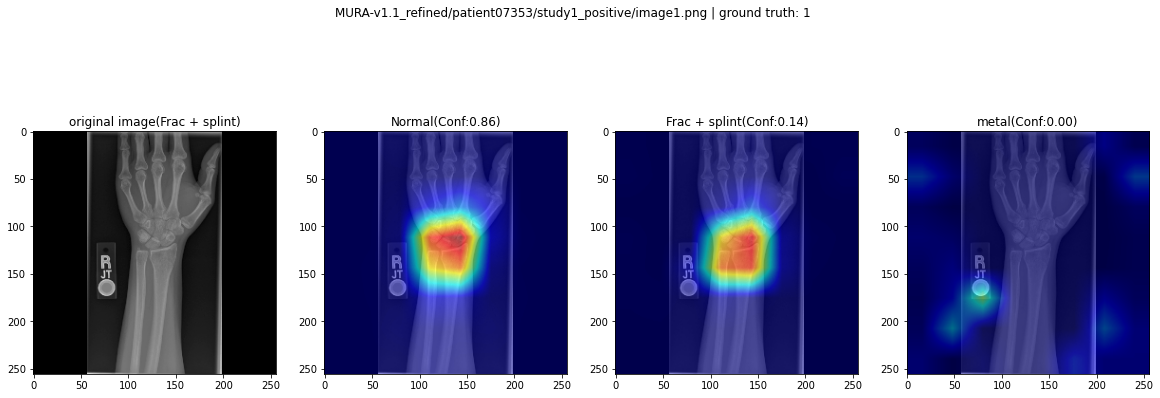

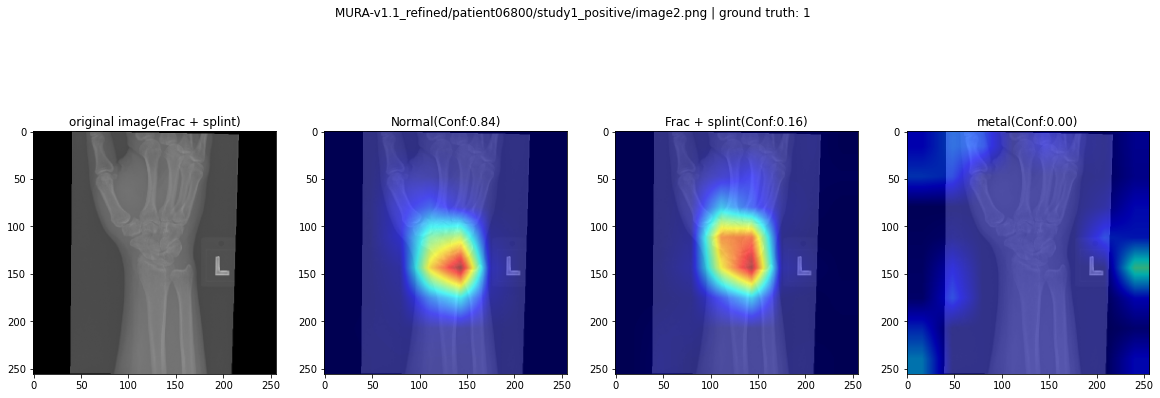

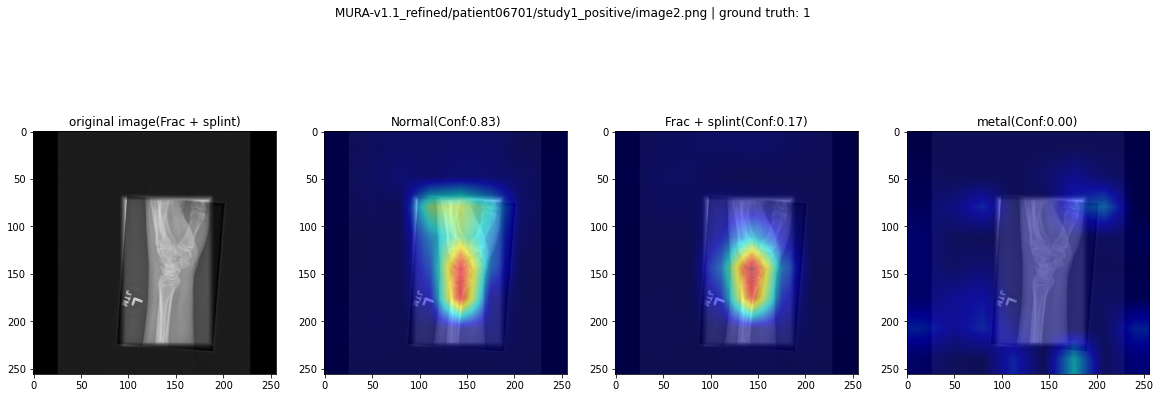

In [55]:
#Top-N FalseNegative

FN_idx_ls = list(test_result_df[test_result_df.Label == _class].sort_values(by=f'Conf_{_class}',ascending=True).index)

target_layer = [test_model.layer4[-1]]
cam = GradCAM(model=test_model, target_layers=target_layer, use_cuda=True)

for i in FN_idx_ls[:N]:
    feature, label = test_dataset[i]
    img, _ = test_dataset_vis[i]
    feature = torch.unsqueeze(feature, 0)
    img = img.astype(np.float)/255
    
    class_cam_image = []
    
    for l in range(len(LABEL_INT2STR)):
        class_cam = cam(input_tensor=feature, targets=[ClassifierOutputTarget(l)],aug_smooth=True,eigen_smooth=False)
        class_cam = class_cam[0, :]
        class_cam_image.append(show_cam_on_image(img, class_cam, use_rgb=True))
    
    prob = test_model(feature.cuda()).softmax(1)[0].cpu().data.numpy()
    #print(test_model(features.cuda()).softmax(1)[0][1], labels)
    fig,ax = plt.subplots(1, 4, figsize=(20, 15))
    ax[0].imshow(img)
    ax[0].set_title(f'original image({LABEL_INT2STR[label]})')
    for l in range(len(LABEL_INT2STR)):
        ax[l+1].imshow(class_cam_image[l])
        ax[l+1].set_title(f'{LABEL_INT2STR[l]}(Conf:{prob[l]:.2f})')
        
    plt.suptitle(f'{test_dataset.data_path[i]} | ground truth: {label}',y=.73)

### Top-N TruePositive

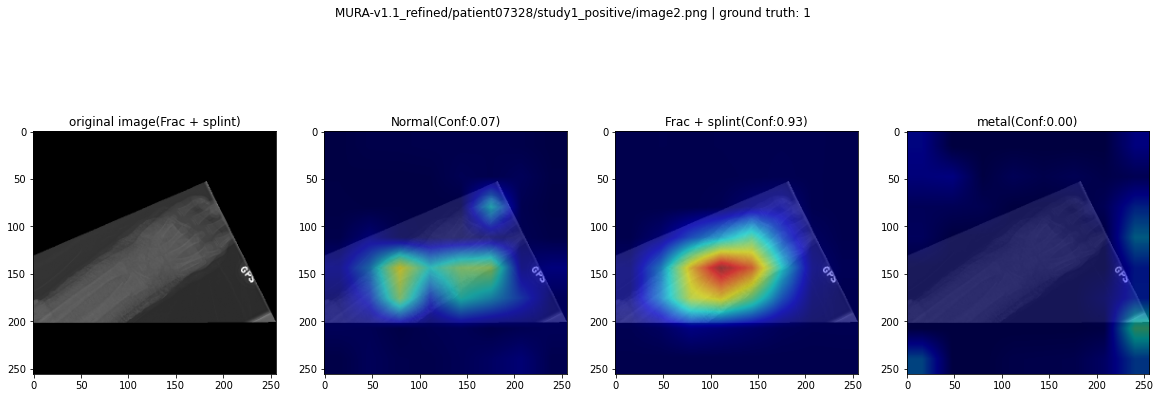

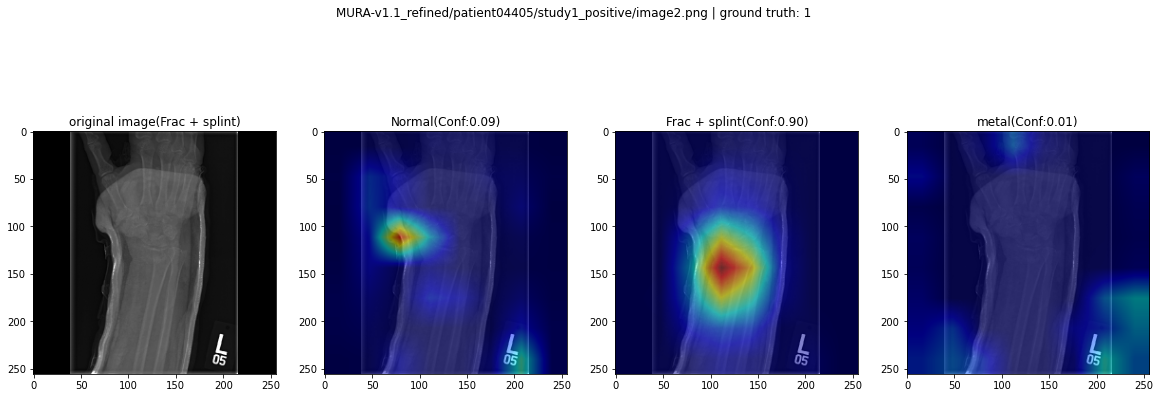

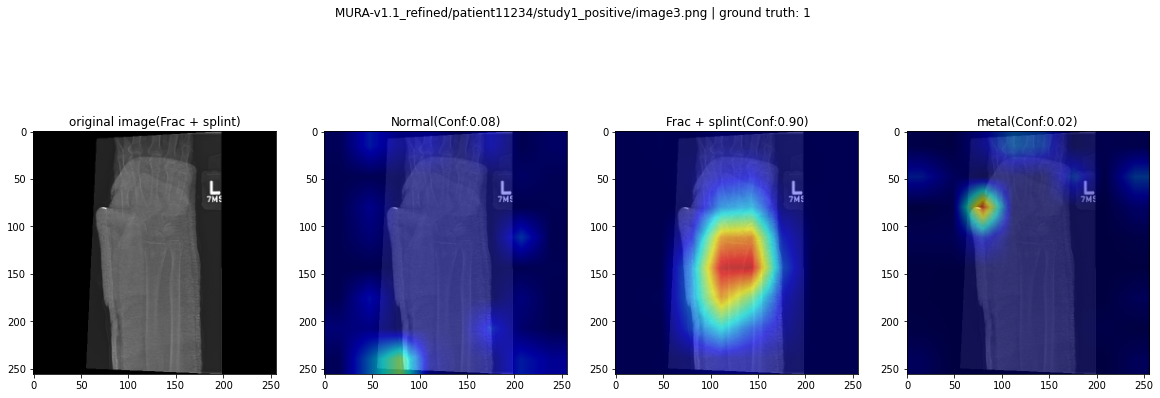

In [69]:
#Top-N TruePositive

TP_idx_ls = list(test_result_df[test_result_df.Label == _class].sort_values(by=f'Conf_{_class}',ascending=False).index)

target_layer = [test_model.layer4[-1]]
cam = GradCAM(model=test_model, target_layers=target_layer, use_cuda=True)

for i in TP_idx_ls[:N]:
    feature, label = test_dataset[i]
    img, _ = test_dataset_vis[i]
    feature = torch.unsqueeze(feature, 0)
    img = img.astype(np.float)/255
    
    class_cam_image = []
    
    for l in range(len(LABEL_INT2STR)):
        class_cam = cam(input_tensor=feature, targets=[ClassifierOutputTarget(l)],aug_smooth=True,eigen_smooth=False)
        class_cam = class_cam[0, :]
        class_cam_image.append(show_cam_on_image(img, class_cam, use_rgb=True))
    
    prob = test_model(feature.cuda()).softmax(1)[0].cpu().data.numpy()
    #print(test_model(features.cuda()).softmax(1)[0][1], labels)
    fig,ax = plt.subplots(1, 4, figsize=(20, 15))
    ax[0].imshow(img)
    ax[0].set_title(f'original image({LABEL_INT2STR[label]})')
    for l in range(len(LABEL_INT2STR)):
        ax[l+1].imshow(class_cam_image[l])
        ax[l+1].set_title(f'{LABEL_INT2STR[l]}(Conf:{prob[l]:.2f})')
        
    plt.suptitle(f'{test_dataset.data_path[i]} | ground truth: {label}',y=.73)

## Voting

In [71]:
test_result_df

Filedir    Conf_0    Conf_1  \
0     MURA-v1.1_refined/patient00077/study1_positive...  0.051716  0.042734   
1     MURA-v1.1_refined/patient00077/study1_positive...  0.059207  0.099995   
2     MURA-v1.1_refined/patient00077/study1_positive...  0.052319  0.029379   
3     MURA-v1.1_refined/patient00214/study1_positive...  0.020570  0.138194   
4     MURA-v1.1_refined/patient00214/study1_positive...  0.018406  0.105643   
...                                                 ...       ...       ...   
1942  MURA-v1.1_refined/patient11382/study1_negative...  0.720232  0.275973   
1943  MURA-v1.1_refined/patient11382/study1_negative...  0.689429  0.285557   
1944  MURA-v1.1_refined/patient11388/study1_negative...  0.707214  0.289182   
1945  MURA-v1.1_refined/patient11388/study1_negative...  0.760262  0.233117   
1946  MURA-v1.1_refined/patient11388/study1_negative...  0.744406  0.250491   

        Conf_2  Pred  Label  
0     0.905549     2      2  
1     0.840798     2      2  
2     0.918302     2      2  
3     0.841237     2      2  
4     0.875951     2      2  
...        ...   ...    ...  
1942  0.003795     0      0  
1943  0.025014     0      0  
1944  0.003604     0      0  
1945  0.006621     0      0  
1946  0.005103     0      0  

[1947 rows x 6 columns]

In [72]:
test_result_df['Patient'] = test_result_df['Filedir'].map(lambda x: os.path.dirname(x).split('/')[-2])
test_result_df['Study'] = test_result_df['Filedir'].map(lambda x: os.path.dirname(x).split('/')[-1])

In [85]:
pred_vote_df = pd.DataFrame(columns=['Patient', 'Study', 'Pred_vote', 'Label'])

for patient in test_result_df.Patient.unique():
    patient_df = test_result_df[test_result_df.Patient==patient]
    for study in patient_df.Study.unique():
        study_df = patient_df[patient_df.Study == study]
        pred_ls = study_df.Pred.values
        label = study_df.Label.values[0]
        
        if 1 in pred_ls:
            pred_vote_df = pred_vote_df.append(pd.DataFrame([[patient, study, 1, label]], 
                                                            columns=['Patient', 'Study', 'Pred_vote', 'Label']), ignore_index=True)
            continue
        if 2 in pred_ls:
            pred_vote_df = pred_vote_df.append(pd.DataFrame([[patient, study, 2, label]], 
                                                            columns=['Patient', 'Study', 'Pred_vote', 'Label']), ignore_index=True)
            continue
        pred_vote_df = pred_vote_df.append(pd.DataFrame([[patient, study, 0, label]], 
                                                            columns=['Patient', 'Study', 'Pred_vote', 'Label']), ignore_index=True)

In [94]:
vote_pred_ls = list(pred_vote_df['Pred_vote'].values)
vote_label_ls = list(pred_vote_df['Label'].values)

In [96]:
print(metrics.classification_report(vote_label_ls, vote_pred_ls))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       477
           1       0.87      0.81      0.84        94
           2       0.99      1.00      1.00       136

    accuracy                           0.96       707
   macro avg       0.94      0.93      0.93       707
weighted avg       0.96      0.96      0.96       707



Text(0.5, 51.0, 'Predicted class')

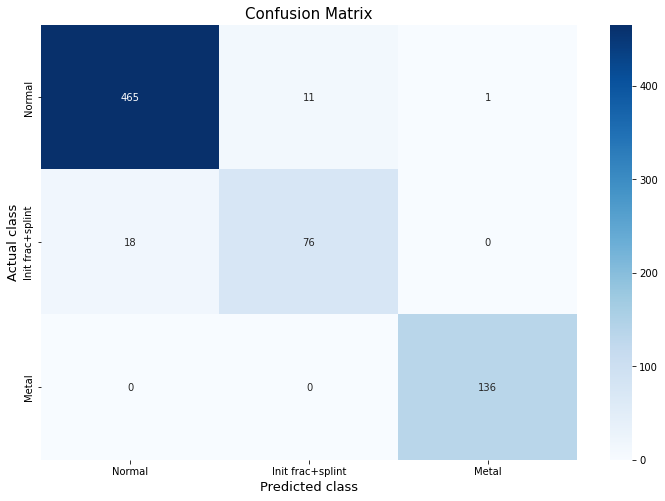

In [97]:
cf_matrix = metrics.confusion_matrix(vote_label_ls, vote_pred_ls)

fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(cf_matrix, 
            xticklabels=class_name, 
            yticklabels=class_name, 
            annot=True, fmt = 'd', cmap='Blues')

plt.title('Confusion Matrix', size = 15)
plt.ylabel('Actual class', size = 13)
plt.xlabel('Predicted class', size = 13) 